<a href="https://colab.research.google.com/github/alejagaco/Prediccion-Precios-Vuelos/blob/main/Prediccion_PreciosVuelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor 
from sklearn.decomposition import PCA

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1,l2

from sklearn.metrics import *


**Precios de vuelos**

Fuente de datos: Kaggle

Link: https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?datasetId=1957837&sortBy=voteCount 

In [3]:
ruta = "/content/drive/MyDrive/Coding Dojo/Proyecto_2/Flight_Predictions.csv"
df = pd.read_csv(ruta)
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


## **Descripción de los datos**

El dataset contiene información de reservas de vuelos realizados en la página web Easemytrip, vuelos realizados entre las ciudadades principales de la India. 



| Variable         | Descripción                                                                                                     |
|------------------|-----------------------------------------------------------------------------------------------------------------|
| Airline          | Aerolinea del vuelo                                                                                             |
| Flight           | Número del vuelo                                                                                                |
| Source city      | Ciudad origen del vuelo                                                                                         |
| Departure time   | Periodo de tiempo de la salida del vuelo: 'Evening', 'Early_Morning','Morning','Afternoon','Night','Late Night' |
| Stops            | Número de escalas: 0, 1, 2 o más                                                                                |
| Arrival time     | Hora de llegada a la ciudad destino                                                                             |
| Destination city | Ciudad destino                                                                                                  |
| Days left        | Diferencia de días entre la fecha de viaje y la fecha en que el tiquete fue reservado                           |
| Price            | Precio del tiquete aéreo                                                                                        |

## Objetivo

Predecir el precio de los tiquetes aereos


¿Este es un problema de clasificación o regresión?: Problema de regresión

¿Qué retos, si es que hay alguno, prevén en la limpieza, exploración o modelización con este conjunto de datos?: 

Con esta data se puede explorar:
* Como varian los precios por aerolinea
* Hay diferencia en el precio si se compra un día antes del vuelo vs varios días
* Como varía el precio según el número de escalas.
* Diferencia en el valor del tiquete para clase economica y ejecutiva

Adicional para predecir el precio de los tiquetes hay que realizar un preprocesamiento ya que la data cuenta con variables ordinales y nominales.


In [5]:
print("El dataset cuenta con ", df.shape[1]-2, " caracteristicas") 
# Se resta la columna objetivo y la columna Unnamed que posteriormente se eliminará

El dataset cuenta con  10  caracteristicas


In [6]:
print("El dataset cuenta con ", df.shape[0], "filas") 

El dataset cuenta con  300153 filas


# EDA

In [7]:
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [8]:
df.drop(columns="Unnamed: 0",inplace=True)

In [9]:
df.duplicated().sum()

0

In [10]:
df.describe()

,duration,days_left,price
count,300153.000000,300153.000000,300153.000000
mean,12.221021,26.004751,20889.660523
std,7.191997,13.561004,22697.767366
min,0.830000,1.000000,1105.000000
25%,6.830000,15.000000,4783.000000
50%,11.250000,26.000000,7425.000000
75%,16.170000,38.000000,42521.000000
max,49.830000,49.000000,123071.000000


In [11]:
df['stops'].unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [12]:
df['class'].unique()

array(['Economy', 'Business'], dtype=object)

In [13]:
df['airline'].unique()

array(['SpiceJet', 'AirAsia', 'Vistara', 'GO_FIRST', 'Indigo',
       'Air_India'], dtype=object)

In [14]:
df['airline'] = df['airline'].str.capitalize()

In [15]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Spicejet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,Spicejet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,Airasia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [16]:
df['class'].value_counts(normalize=True)

Economy     0.688536
Business    0.311464
Name: class, dtype: float64

## Visualization

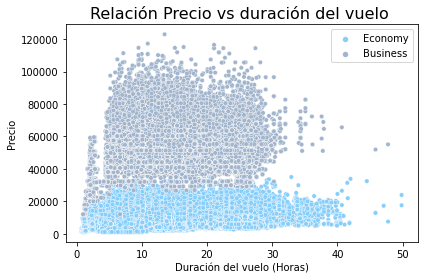

In [17]:
color = ['#87CEFA','#A2B5CD']
sns.scatterplot(data=df, x ='duration', y='price', hue='class', size='class',sizes=(20, 20), palette=color)

plt.title('Relación Precio vs duración del vuelo ', fontsize=16)

plt.xlabel('Duración del vuelo (Horas)', fontsize=10)
plt.ylabel('Precio', fontsize=10)

plt.legend(loc='best')

plt.tight_layout()
plt.show()

De acuerdo con el gráfico anterior se observa como los precios de vuelos mas elevados son en la clase Business, y adicional se evidencia algunos valores atípicos en el precio de esta clase, donde fueron obtenidos a precios similares a los de la clase económica.

In [18]:
# Para cada ciudad origen cuantas ciudades destinos hay
df.groupby(['source_city'])[['destination_city']].nunique().reset_index().sort_values(by='destination_city',ascending=False)

,source_city,destination_city
0,Bangalore,5
1,Chennai,5
2,Delhi,5
3,Hyderabad,5
4,Kolkata,5
5,Mumbai,5


In [19]:
precio_prom_aerolinea = df.groupby(['airline','class'])[['price']].mean().reset_index().sort_values(by='price',ascending=False)
precio_prom_aerolinea.head()

,airline,class,price
6,Vistara,Business,55477.027777
0,Air_india,Business,47131.039212
7,Vistara,Economy,7806.943645
1,Air_india,Economy,7313.682169
5,Spicejet,Economy,6179.278881


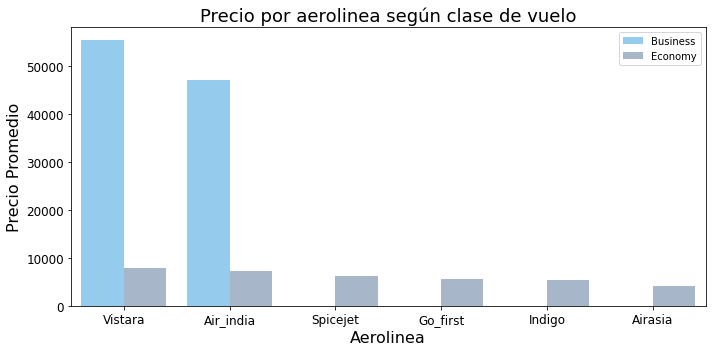

In [20]:
fig, ax = plt.subplots(figsize = (10, 5)) # Definir el tamaño del grafico, ancho, alto

color = ['#87CEFA','#A2B5CD']

ax1 = sns.barplot(data=precio_prom_aerolinea,x='airline',y='price',hue='class',palette=color)

ax1.set_ylabel('Precio Promedio', fontsize=16)
ax1.set_xlabel('Aerolinea', fontsize=16)

plt.legend(loc='best')  #Ubicación automática para obtener la mejor ubicación
plt.title('Precio por aerolinea según clase de vuelo', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.tight_layout()
plt.show()

Las únicas dos aerolineas que ofrecen clase business son Air_India y Vistara, teniendo esta última un precio promedio mas elevado que Air_India. De igual forma, se aprecia que la aerolinea Airasia ofrece precios inferiores a las demas aerolineas

In [21]:
df_economic = df[df['class']=='Economy'].reset_index(drop=True)
df_economic = df_economic.groupby(['airline','days_left'])[['price']].mean().reset_index()

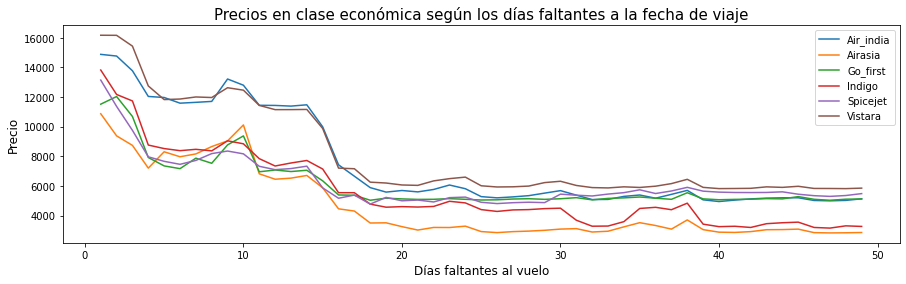

In [22]:
plt.figure(figsize=(15,4))
sns.lineplot(data=df_economic,x='days_left',y='price',color='blue',hue='airline')
plt.title('Precios en clase económica según los días faltantes a la fecha de viaje',fontsize=15)
plt.legend(fontsize=10)
plt.xlabel('Días faltantes al vuelo',fontsize=12)
plt.ylabel('Precio',fontsize=12)
plt.show()

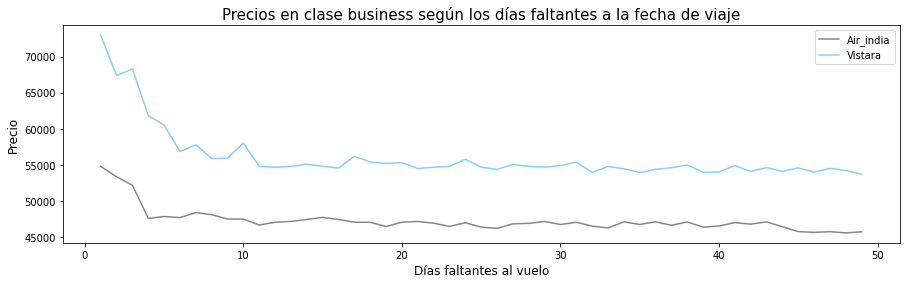

In [23]:
df_business = df[df['class']!='Economy'].reset_index(drop=True)
df_business = df_business.groupby(['airline','days_left'])[['price']].mean().reset_index()
plt.figure(figsize=(15,4))
colors =['#8B8386','#87CEFA']
sns.lineplot(data=df_business,x='days_left',y='price',hue='airline', palette=colors)
plt.title('Precios en clase business según los días faltantes a la fecha de viaje',fontsize=15)
plt.legend(fontsize=10)
plt.xlabel('Días faltantes al vuelo',fontsize=12)
plt.ylabel('Precio',fontsize=12)
plt.show()

In [24]:
df_economic.sort_values(by='price',ascending=True,inplace=True)

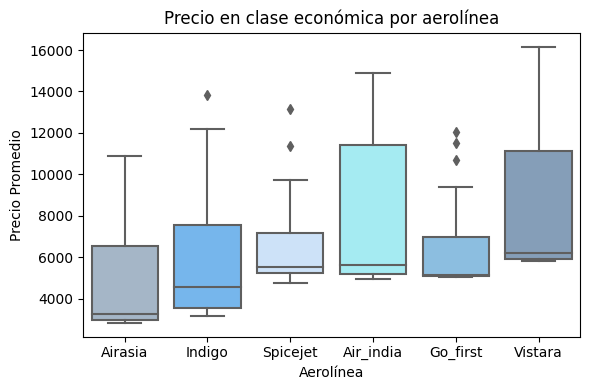

In [25]:
color = ['#9FB6CD','#63B8FF','#C6E2FF','#98F5FF','#7EC0EE','#7D9EC0']

fig1=plt.figure(dpi=100);

sns.boxplot(data=df_economic,x='airline',y='price',palette=color)

plt.xlabel('Aerolínea', fontsize=10)
plt.ylabel('Precio Promedio', fontsize=10)

plt.title("Precio en clase económica por aerolínea")

plt.tight_layout()
plt.show()

In [26]:
# Precio promedio de cada trayecto según la hora de salida para la clase económica
precio_prom_time = df[df['class']=='Economy'].reset_index(drop=True)
precio_prom_time = precio_prom_time.groupby(['airline','departure_time','days_left'])[['price']].mean().sort_values(by='price',ascending=True).reset_index()
precio_prom_time.head()

,airline,departure_time,days_left,price
0,Airasia,Night,34,2570.407895
1,Airasia,Night,41,2570.407895
2,Airasia,Night,47,2571.022472
3,Airasia,Night,33,2583.250000
4,Airasia,Night,42,2588.710526


<Figure size 600x400 with 0 Axes>

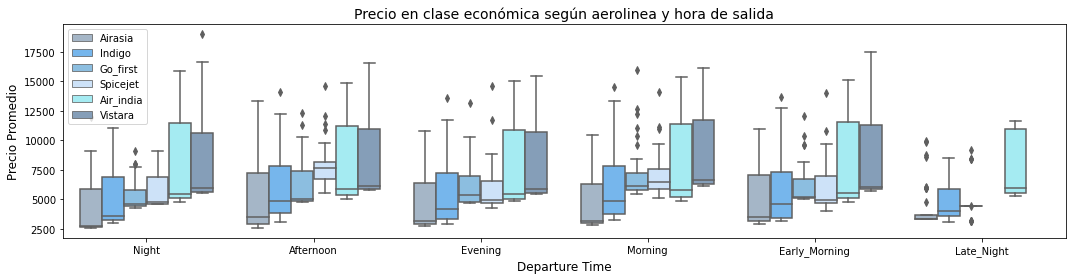

In [27]:
color = ['#9FB6CD','#63B8FF','#7EC0EE','#C6E2FF','#98F5FF','#7D9EC0']

fig1=plt.figure(dpi=100);
plt.figure(figsize=(15,4))
sns.boxplot(data=precio_prom_time,x='departure_time',y='price',hue='airline',palette=color)

plt.xlabel('Departure Time', fontsize=12)
plt.ylabel('Precio Promedio', fontsize=12)

plt.legend(loc='best')

plt.title("Precio en clase económica según aerolinea y hora de salida", fontsize=14)

plt.tight_layout()
plt.show()

Se confirma que la aerolinea Air Asia es la que ofrece los precios mas bajos independientemente de la hora de salida.  Vistara y Air India ofrecen los precios mas altos.

In [28]:
# Precio promedio de cada trayecto según # de escalas para la clase económica
precio_prom_stops = df[df['class']=='Economy'].reset_index(drop=True)
precio_prom_stops = df.groupby(['airline','stops'])[['price']].mean().reset_index().sort_values(by='price',ascending=False)
precio_prom_stops.head()

,airline,stops,price
14,Vistara,one,32353.149720
0,Air_india,one,24805.782885
15,Vistara,two_or_more,18850.767996
16,Vistara,zero,16416.273587
2,Air_india,zero,14403.191918


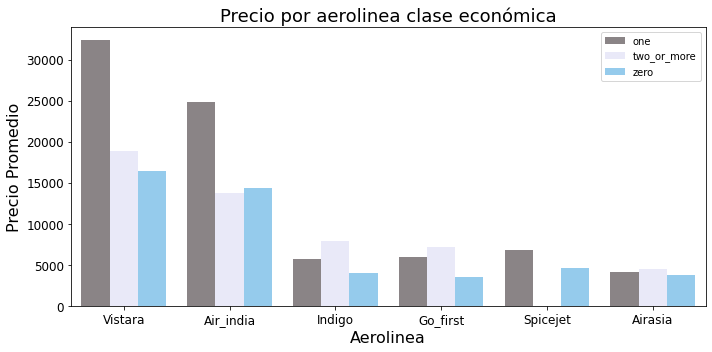

In [29]:
fig, ax = plt.subplots(figsize = (10, 5)) # Definir el tamaño del grafico, ancho, alto

colors =['#8B8386','#E6E6FA','#87CEFA']

ax1 = sns.barplot(data=precio_prom_stops,x='airline',y='price',hue='stops', palette=colors)
                  #palette=("ch:2.5,-.2,dark=.3")


ax1.set_ylabel('Precio Promedio', fontsize=16)
ax1.set_xlabel('Aerolinea', fontsize=16)

plt.legend(loc='best')  #Ubicación automática para obtener la mejor ubicación
plt.title('Precio por aerolinea clase económica', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

fig.tight_layout()
plt.show()

El precio promedio mas bajo es para los vuelos directos o que no tienen escala para todas las aerolíneas a excepción de Air India.
La aerolinea Spice Jet no ofrece vuelos con 2 o mas escalas. 

Para las aerolineas Indigo, Go first y Air Asia es mas costoso los vuelos que tienen 2 o mas escalas; mientras que para Vistara, Air India y SpiceJet es mas costoso los vuelos con 1 escala.

In [30]:
df_aerolineas = df.groupby(['airline'])[['price']].count().sort_values(by='price',ascending=False).reset_index()
df_aerolineas.rename(columns={'price':'Muestra'},inplace=True)
df_aerolineas

,airline,Muestra
0,Vistara,127859
1,Air_india,80892
2,Indigo,43120
3,Go_first,23173
4,Airasia,16098
5,Spicejet,9011


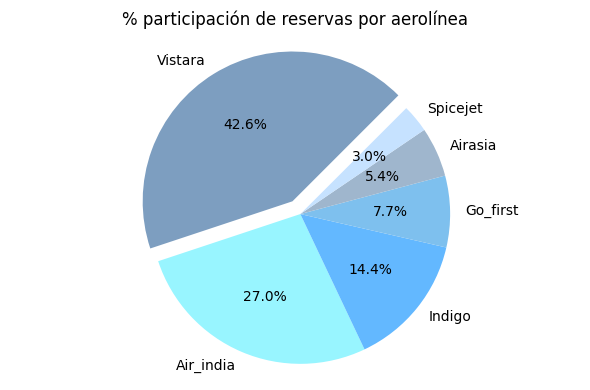

In [31]:
muestra = df_aerolineas['Muestra']
aerolinea = df_aerolineas['airline']


fig = plt.figure(dpi=100)
ax = fig.add_subplot(1,1,1)

explotar=[0.1,0,0,0,0,0]  # Para resaltar la categoria Upheld Complaints
colores = ['#7D9EC0','#98F5FF','#63B8FF','#7EC0EE','#9FB6CD','#C6E2FF']

def absolute_value(val):
  a = np.round(val,1)
  return a   #Para agregar los valores (%) en el pie

ax.pie(muestra, labels=aerolinea, explode=explotar, shadow=False, startangle=45, autopct='%.1f%%', colors= colores)
ax.axis("equal") ;

plt.title("% participación de reservas por aerolínea")
plt.tight_layout() #Para ajustar el gráfico
plt.show();

El 43% de los vuelos fueron realizados a través de la aerolinea Vistara, y la aerolinea menos utilizada fue Spicejet con un 3%.

In [32]:
df['Trayecto'] = df['source_city'] +' - ' +df['destination_city']
df_trayecto = df.groupby(['airline','Trayecto'])[['price']].count().reset_index()
df_tray = df_trayecto.groupby(['airline'])[['Trayecto']].count().sort_values(by='Trayecto',ascending=False).reset_index()
df_tray.head(10)

,airline,Trayecto
0,Air_india,30
1,Airasia,30
2,Go_first,30
3,Indigo,30
4,Vistara,30
5,Spicejet,27


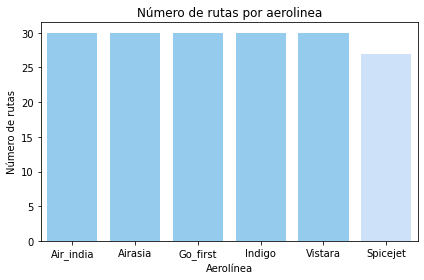

In [33]:
color = ['#87CEFA','#87CEFA','#87CEFA','#87CEFA','#87CEFA','#C6E2FF']

sns.barplot(data=df_tray, x='airline',y='Trayecto',palette=color)

plt.title('Número de rutas por aerolinea', fontsize=12)

plt.xlabel('Aerolínea', fontsize=10)
plt.ylabel('Número de rutas', fontsize=10)


plt.tight_layout()
plt.show()

De las 6 aerolineas analizadas, 5 ofrecen 30 rutas a excepción de Spicejet que ofrece 27 rutas.

In [34]:
# Rutas de la aerolinea Vistara en clase economica
df_vistara = df[(df['airline']=='Vistara') &(df['class']=='Economy') ].reset_index(drop=True)
vistara_top = df_vistara.groupby(['Trayecto'])[['price']].count().sort_values(by='price',ascending=False).reset_index()
vistara_top.rename(columns={'price':'Num viajes'},inplace=True)
vistara = df_vistara.groupby(['Trayecto','days_left'])[['price']].mean().sort_values(by='price',ascending=False).reset_index()
vistara.rename(columns={'price':'precio_prom'},inplace=True)
vistara.head(), vistara_top.head()

(              Trayecto  days_left   precio_prom
 0  Hyderabad - Kolkata          2  21510.200000
 1    Chennai - Kolkata          2  21453.071429
 2     Chennai - Mumbai          2  20368.333333
 3  Chennai - Bangalore          2  20364.640000
 4    Kolkata - Chennai          1  19902.750000,
              Trayecto  Num viajes
 0      Delhi - Mumbai        2928
 1      Mumbai - Delhi        2920
 2   Delhi - Bangalore        2723
 3   Bangalore - Delhi        2709
 4  Bangalore - Mumbai        2651)

In [35]:
vistara_top4 = vistara[((vistara['Trayecto']=='Delhi - Mumbai') | (vistara['Trayecto']=='Mumbai - Delhi')) |
                       ((vistara['Trayecto']=='Delhi - Bangalore') | (vistara['Trayecto']=='Bangalore - Delhi'))]  #Bangalore - Mumbai

In [36]:
# Rutas de la aerolinea Air India en clase economica
df_airindia = df[(df['airline']=='Air_india') &(df['class']=='Economy') ].reset_index(drop=True)
airindia_top = df_airindia.groupby(['Trayecto'])[['price']].count().sort_values(by='price',ascending=False).reset_index()
airindia_top.rename(columns={'price':'Num viajes'},inplace=True)
airindia = df_airindia.groupby(['Trayecto','days_left'])[['price']].mean().sort_values(by='price',ascending=False).reset_index()
airindia.rename(columns={'price':'precio_prom'},inplace=True)
airindia.head(), airindia_top.head()

(              Trayecto  days_left   precio_prom
 0    Chennai - Kolkata          1  33540.333333
 1  Chennai - Bangalore          1  27681.000000
 2  Hyderabad - Chennai          1  26020.000000
 3     Chennai - Mumbai          1  25833.000000
 4  Hyderabad - Kolkata          1  24640.428571,
              Trayecto  Num viajes
 0      Delhi - Mumbai        2612
 1      Mumbai - Delhi        2534
 2  Mumbai - Hyderabad        2266
 3     Delhi - Kolkata        2200
 4  Mumbai - Bangalore        2174)

In [37]:
airindia_top4 = airindia[((airindia['Trayecto']=='Delhi - Mumbai') | (airindia['Trayecto']=='Mumbai - Delhi')) |
                       ((airindia['Trayecto']=='Mumbai - Hyderabad') | (airindia['Trayecto']=='Delhi - Kolkata'))]

<Figure size 780x520 with 0 Axes>

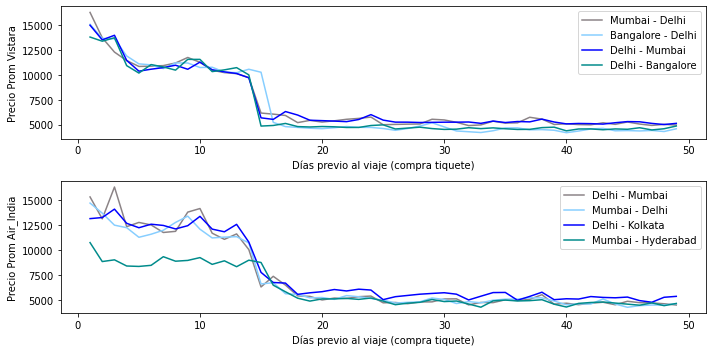

In [38]:
fig = plt.figure(dpi = 130)
fig,(ax0,ax1) = plt.subplots(2,1,figsize = (10, 5)) # Definir el tamaño del grafico, ancho, alto

color = ['#8B8386','#87CEFF','blue','#008B8B']

sns.lineplot(data=vistara_top4,x='days_left',y='precio_prom',hue='Trayecto', palette= color, ax=ax0)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax0.legend(loc='best')  #Ubicación automática para obtener la mejor ubicación

ax0.set_ylabel('Precio Prom Vistara', fontsize=10)
ax0.set_xlabel('Días previo al viaje (compra tiquete)', fontsize=10)

sns.lineplot(data=airindia_top4,x='days_left',y='precio_prom',hue='Trayecto', palette= color, ax=ax1)

ax1.set_ylabel('Precio Prom Air_India', fontsize=10)
ax1.set_xlabel('Días previo al viaje (compra tiquete)', fontsize=10)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
ax1.legend(loc='best')  #Ubicación automática para obtener la mejor ubicación

fig.tight_layout()
plt.show()

Analizando el top 4 de las rutas de las aerolineas Vistara y Air India en clase economica, se observa como los precios aumentan considerablemente a los 15 días antes del vuelo.

Es decir que si un pasajero desea comprar un tiquete a buen precio será mejor que lo compre mínimo a 20 días restantes para el vuelo.

In [39]:
df_trayecto = df.groupby(['airline','Trayecto','class']).agg({'days_left':'count', 'price':'mean'}).reset_index()
df_trayecto.head()

,airline,Trayecto,class,days_left,price
0,Air_india,Bangalore - Chennai,Business,621,56301.932367
1,Air_india,Bangalore - Chennai,Economy,989,8219.478261
2,Air_india,Bangalore - Delhi,Business,1083,40608.953832
3,Air_india,Bangalore - Delhi,Economy,1550,6787.892258
4,Air_india,Bangalore - Hyderabad,Business,791,51169.902655


In [40]:
# Top 10 de las rutas en clase económicas

df_trayecto.rename(columns={'days_left':'Conteo','price':'precio_prom'},inplace=True)
df_trayecto_economico = df_trayecto[df_trayecto['class']=='Economy'].reset_index(drop=True)
rutas = df_trayecto_economico.groupby(['Trayecto']).agg({'Conteo':'sum','precio_prom':'mean'}).reset_index()
rutas.sort_values(by=['Conteo'],ascending=False,inplace=True)
Top10_rutas = rutas.head(10).reset_index(drop=True)
Top10_rutas

,Trayecto,Conteo,precio_prom
0,Delhi - Bangalore,10144,6175.865765
1,Delhi - Mumbai,9982,5471.005764
2,Bangalore - Delhi,9959,6133.386436
3,Mumbai - Delhi,9801,5308.613455
4,Mumbai - Kolkata,8774,6685.180814
5,Bangalore - Mumbai,8743,5846.732524
6,Mumbai - Bangalore,8706,5790.992658
7,Delhi - Kolkata,8654,6685.887728
8,Kolkata - Mumbai,8103,6776.460793
9,Kolkata - Delhi,7816,6877.446568


In [41]:
# Filtrar las rutas Delhi - Bangalore y Bangalore - Delhi de las clase económica
top1 = df[((df['Trayecto']=="Delhi - Bangalore") | (df['Trayecto']=="Bangalore - Delhi")) & (df['class']=='Economy')].reset_index(drop=True)
#top1.head()

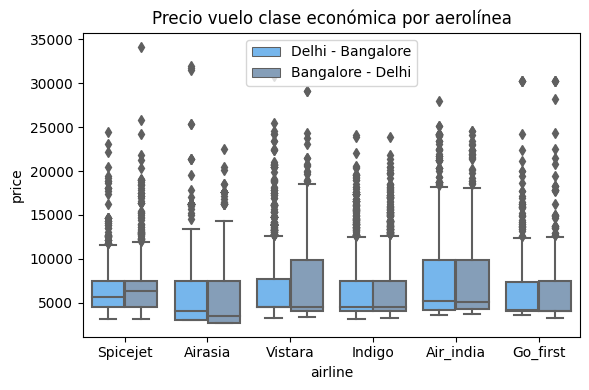

In [42]:
color = ['#63B8FF','#7D9EC0']

fig1=plt.figure(dpi=100);

sns.boxplot(data=top1,x='airline',y='price',hue='Trayecto',palette=color)

plt.legend(loc='best')

plt.title("Precio vuelo clase económica por aerolínea")

plt.tight_layout()
plt.show()

Analizando los precios de la clase economica de la ruta Top1 Delhi - Bangalore y su regreso, para todas las aerolineas, se obtiene:

* La aerolinea con mejores precios es Air Asia
* La aerolinea con mayor precio es Air India
* Se observa en cada aerolinea valores atípicos, de acuerdo al gráfico anterior se concluye que estos valores corresponde a los precios de los tiquetes adquiridos 15 días o menos al día del viaje

<Figure size 900x600 with 0 Axes>

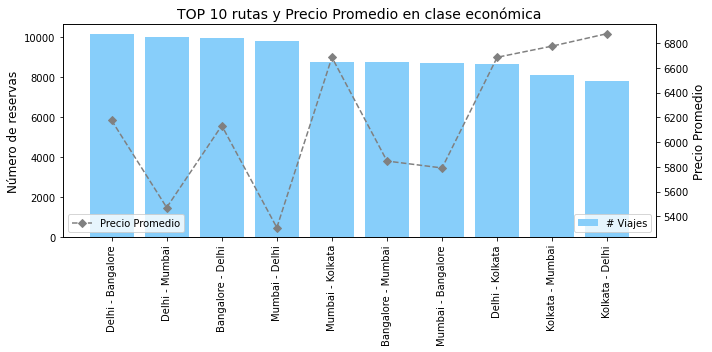

In [43]:
fig1=plt.figure(dpi=150);
fig1,ax1 = plt.subplots(figsize = (10, 5));

ax2 = ax1.twinx()

ax1.bar(Top10_rutas['Trayecto'],Top10_rutas['Conteo'],color='#87CEFA',label='# Viajes')
ax1.set_xticklabels(Top10_rutas['Trayecto'], rotation=90, fontsize=10);
#ax1.grid(b=False, linestyle='-.',linewidth= 0.5, alpha=0.6)

ax2.plot(Top10_rutas['Trayecto'],Top10_rutas['precio_prom'],'gD--',color='grey',label='Precio Promedio')

ax1.set_ylabel('Número de reservas',fontsize=12)
ax2.set_ylabel('Precio Promedio',fontsize=12)

plt.title('TOP 10 rutas y Precio Promedio en clase económica', fontsize=14)
ax1.legend(loc='lower right') 
ax2.legend(loc='lower left') 

fig1.tight_layout();
plt.show()

De acuerdo con el top 10 de las rutas se observa: 

* La ruta mas viajada es Delhi-Bangalore el cual tiene un precio promedio de 6.000 para la clase económica.
* En el puesto 10 esta la ruta Kolkata - Delhi con 7.816 tiquetes comprados, sin embargo con el precio promedio mas alto en clase económica, 6.877



In [44]:
# Se reemplaza el número de escalas por números
# Zero: 0
# One: 1
# Two or more: 2
df['stops'].replace({'zero':0,'one':1,'two_or_more':2},inplace=True)

In [45]:
# Se reemplaza economic por 0 y Bussiness y 1
df['class'].replace({'Economy':0,'Business':1},inplace=True)

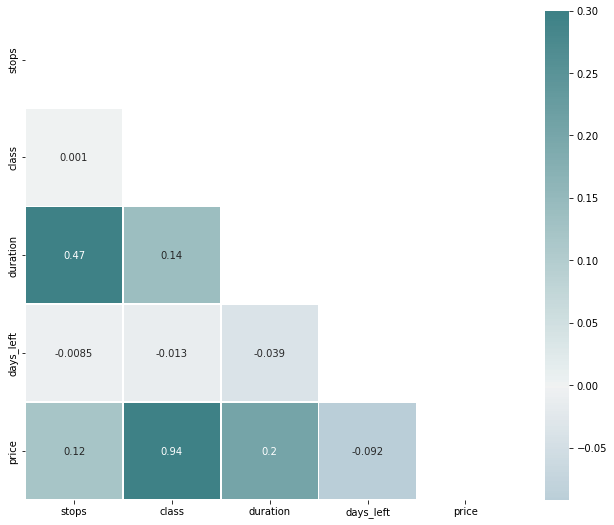

In [46]:
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
# Set up the matplotlib figure
plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 200, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(df.corr(), annot=True,mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1.0})

La variable que tiene una mayor relación con el precio es la clase de viaje, tiene una relación directa del 94%.

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   airline           300153 non-null  object 
 1   flight            300153 non-null  object 
 2   source_city       300153 non-null  object 
 3   departure_time    300153 non-null  object 
 4   stops             300153 non-null  int64  
 5   arrival_time      300153 non-null  object 
 6   destination_city  300153 non-null  object 
 7   class             300153 non-null  int64  
 8   duration          300153 non-null  float64
 9   days_left         300153 non-null  int64  
 10  price             300153 non-null  int64  
 11  Trayecto          300153 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 27.5+ MB


In [48]:
dfcar = df.copy()
dfcar.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price,Trayecto
0,Spicejet,SG-8709,Delhi,Evening,0,Night,Mumbai,0,2.17,1,5953,Delhi - Mumbai
1,Spicejet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,0,2.33,1,5953,Delhi - Mumbai
2,Airasia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,0,2.17,1,5956,Delhi - Mumbai
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,0,2.25,1,5955,Delhi - Mumbai
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,0,2.33,1,5955,Delhi - Mumbai


In [49]:
dfcar.drop(['source_city','destination_city'],axis=1,inplace=True)
dfcar.head()

,airline,flight,departure_time,stops,arrival_time,class,duration,days_left,price,Trayecto
0,Spicejet,SG-8709,Evening,0,Night,0,2.17,1,5953,Delhi - Mumbai
1,Spicejet,SG-8157,Early_Morning,0,Morning,0,2.33,1,5953,Delhi - Mumbai
2,Airasia,I5-764,Early_Morning,0,Early_Morning,0,2.17,1,5956,Delhi - Mumbai
3,Vistara,UK-995,Morning,0,Afternoon,0,2.25,1,5955,Delhi - Mumbai
4,Vistara,UK-963,Morning,0,Morning,0,2.33,1,5955,Delhi - Mumbai


In [50]:
df.drop(columns='Trayecto',inplace=True)
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,Spicejet,SG-8709,Delhi,Evening,0,Night,Mumbai,0,2.17,1,5953
1,Spicejet,SG-8157,Delhi,Early_Morning,0,Morning,Mumbai,0,2.33,1,5953
2,Airasia,I5-764,Delhi,Early_Morning,0,Early_Morning,Mumbai,0,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,0,Afternoon,Mumbai,0,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,0,Morning,Mumbai,0,2.33,1,5955


# Machine Learning

In [51]:
df['flight'].nunique()

1561

In [52]:
df.drop(columns='flight',inplace=True) 
#La columna flight no es relevante para la predicción del precio

In [53]:
df = pd.get_dummies(df,prefix=['airline','source_city','departure_time','arrival_time','destination_city'])

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 35 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   stops                         300153 non-null  int64  
 1   class                         300153 non-null  int64  
 2   duration                      300153 non-null  float64
 3   days_left                     300153 non-null  int64  
 4   price                         300153 non-null  int64  
 5   airline_Air_india             300153 non-null  uint8  
 6   airline_Airasia               300153 non-null  uint8  
 7   airline_Go_first              300153 non-null  uint8  
 8   airline_Indigo                300153 non-null  uint8  
 9   airline_Spicejet              300153 non-null  uint8  
 10  airline_Vistara               300153 non-null  uint8  
 11  source_city_Bangalore         300153 non-null  uint8  
 12  source_city_Chennai           300153 non-nul

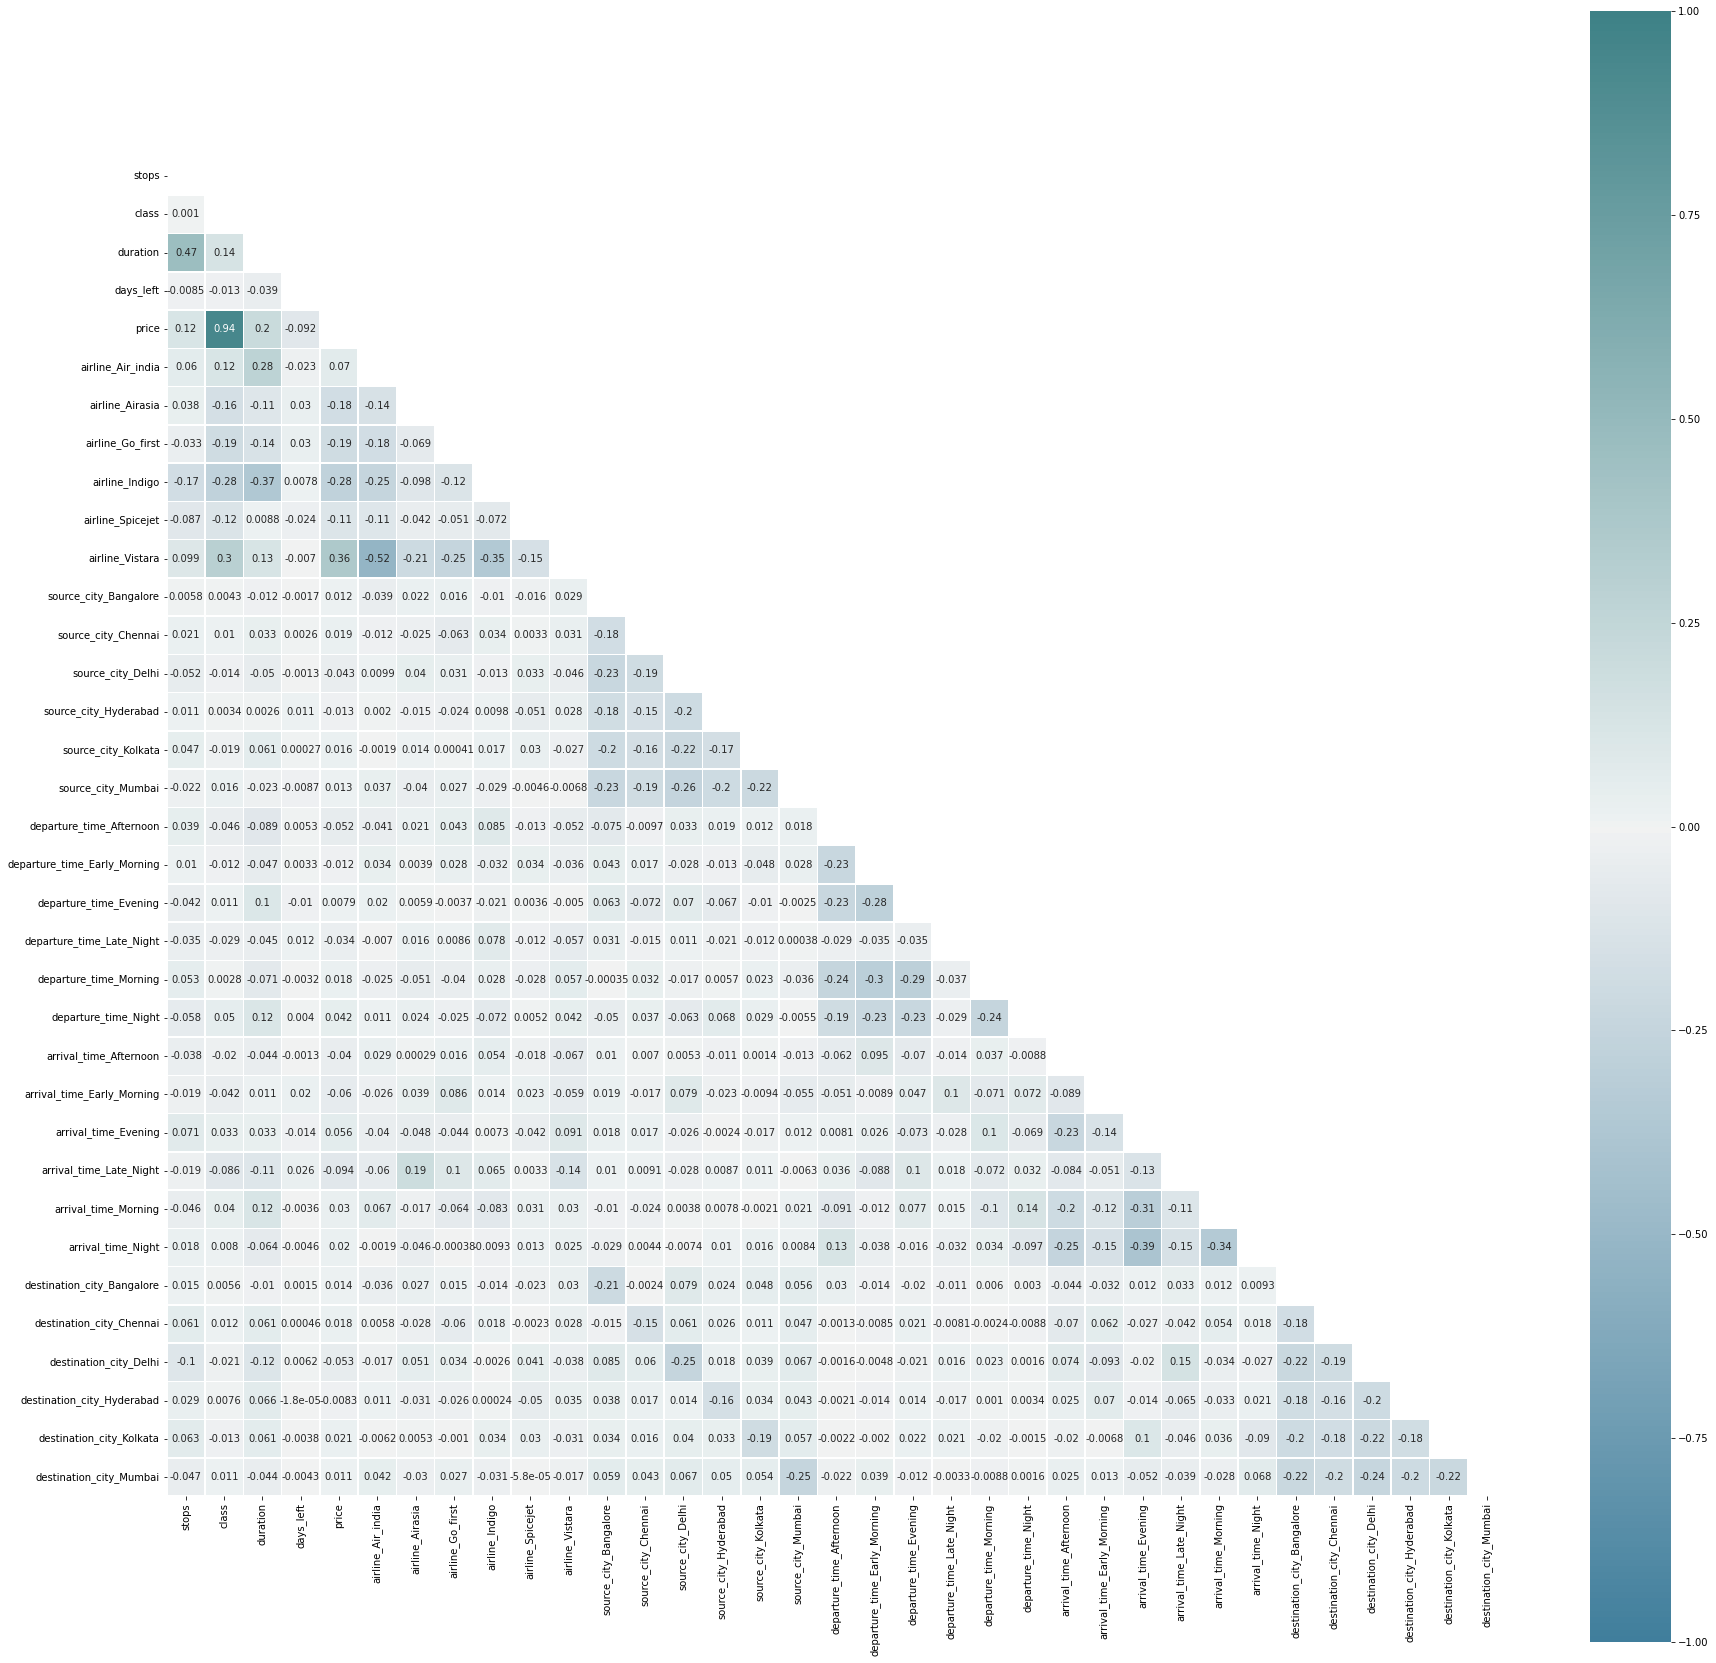

In [55]:
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(230, 200, as_cmap=True)
sns.heatmap(df.corr(), annot=True,
            mask=mask, 
            cmap=cmap, vmin= -1.0,vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": 1})

In [56]:
# Matriz de característca y objetivo
X = df.drop(columns='price')
y = df['price']

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42, train_size=0.9)

In [58]:
scaler = StandardScaler()

In [59]:
np.set_printoptions(suppress=True)

In [60]:
modelo1 = LinearRegression()
reg = make_pipeline(scaler,modelo1)
reg.fit(X_train,y_train)
test_preds_reg = reg.predict(X_test)
r2_reg = round(reg.score(X_test, y_test),4)
mae_reg = round(mean_absolute_error(y_test,test_preds_reg),3)
mse_reg = round(mean_squared_error(y_test, test_preds_reg),3)
rmse_reg = round(np.sqrt(mean_squared_error(y_test,test_preds_reg)))
print("Score Train: ",round(reg.score(X_train, y_train),3))
print("Score Test: ",round(reg.score(X_test, y_test),3))
print("mae test", round(mean_absolute_error(y_test,test_preds_reg),3))
print("mse test", round(mean_squared_error(y_test, test_preds_reg),3))
print("rmse test", round(np.sqrt(mean_squared_error(y_test,test_preds_reg))))

Score Train:  0.91
Score Test:  0.91
mae test 4497.559
mse test 46331423.448
rmse test 6807


In [61]:
modelo2 = DecisionTreeRegressor()
dt= make_pipeline(scaler,modelo2)
dt.fit(X_train,y_train)
test_preds_dt = dt.predict(X_test)
r2_dt = round(dt.score(X_test, y_test),4)
mae_dt = round(mean_absolute_error(y_test,test_preds_dt),3)
mse_dt = round(mean_squared_error(y_test, test_preds_dt),3)
rmse_dt = round(np.sqrt(mean_squared_error(y_test,test_preds_dt)))
print("Score Train: ",round(dt.score(X_train, y_train),3))
print("Score Test: ",round(dt.score(X_test, y_test),3))
print("mae test", round(mean_absolute_error(y_test,test_preds_dt),3))
print("mse test", round(mean_squared_error(y_test, test_preds_dt),3))
print("rmse test", round(np.sqrt(mean_squared_error(y_test,test_preds_dt))))

Score Train:  0.999
Score Test:  0.976
mae test 1154.207
mse test 12369149.722
rmse test 3517


In [62]:
modelo3 = RandomForestRegressor(n_estimators=100, random_state=42)
rf= make_pipeline(scaler,modelo3)
rf.fit(X_train,y_train)
test_preds_rf = rf.predict(X_test)
r2_rf = round(rf.score(X_test, y_test),4)
mae_rf = round(mean_absolute_error(y_test,test_preds_rf),3)
mse_rf = round(mean_squared_error(y_test, test_preds_rf),3)
rmse_rf = round(np.sqrt(mean_squared_error(y_test,test_preds_rf)))
print("Score Train: ",round(rf.score(X_train, y_train),3))
print("Score Test: ",round(rf.score(X_test, y_test),3))
print("mae test", round(mean_absolute_error(y_test,test_preds_rf),3))
print("mse test", round(mean_squared_error(y_test, test_preds_rf),3))
print("rmse test", round(np.sqrt(mean_squared_error(y_test,test_preds_rf))))

Score Train:  0.997
Score Test:  0.985
mae test 1060.9
mse test 7561952.944
rmse test 2750


In [63]:
modelo4 = BaggingRegressor(DecisionTreeRegressor(),n_estimators=100, max_samples=200,
                           bootstrap=True, # Si se desea probar pasting, cambiar parámetro bootstrap=False 
                           random_state=42)
br= make_pipeline(scaler,modelo4)
br.fit(X_train,y_train)
test_preds_br = br.predict(X_test)
r2_br = round(br.score(X_test, y_test),4)
mae_br = round(mean_absolute_error(y_test,test_preds_br),3)
mse_br = round(mean_squared_error(y_test, test_preds_br),3)
rmse_br = round(np.sqrt(mean_squared_error(y_test,test_preds_br)))
print("Score Train: ",round(br.score(X_train, y_train),3))
print("Score Test: ",round(br.score(X_test, y_test),3))
print("mae test", round(mean_absolute_error(y_test,test_preds_br),3))
print("mse test", round(mean_squared_error(y_test, test_preds_br),3))
print("rmse test", round(np.sqrt(mean_squared_error(y_test,test_preds_br))))

Score Train:  0.948
Score Test:  0.947
mae test 3065.322
mse test 27307904.88
rmse test 5226


In [64]:
np.set_printoptions(suppress=True)

In [65]:
resumen_metricas = pd.DataFrame(columns=['Modelo', 'r2', 'mae','mse','rmse'])
resumen_metricas['Modelo'] = ['Linear Regression','Decision Tree', 'Random Forest Regressor','Bagging Regressor']
resumen_metricas['r2'] = [r2_reg, r2_dt,r2_rf,r2_br]
resumen_metricas['mae'] = [mae_reg, mae_dt,mae_rf,mae_br]
resumen_metricas['mse'] = [round(mse_reg,2), mse_dt,mse_rf,mse_br]
resumen_metricas['rmse'] = [rmse_reg, rmse_dt,rmse_rf,rmse_br]
resumen_metricas

,Modelo,r2,mae,mse,rmse
0,Linear Regression,0.9100,4497.559,4.633142e+07,6807
1,Decision Tree,0.9760,1154.207,1.236915e+07,3517
2,Random Forest Regressor,0.9853,1060.900,7.561953e+06,2750
3,Bagging Regressor,0.9470,3065.322,2.730790e+07,5226


## **APC**

In [66]:
# Escalar los datos
scaler = StandardScaler()
scaled_df = scaler.fit_transform(X)
pca = PCA()
pca.fit(scaled_df)

PCA()

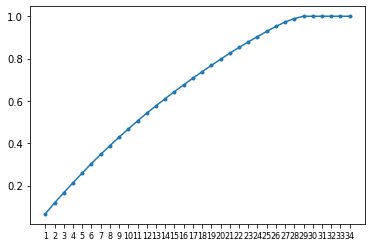

In [67]:
# Graficar la suma acumulativa del porcentaje de la varianza explicada por cada componente
plt.plot(range(1,35),pca.explained_variance_ratio_.cumsum(),marker='.')
plt.xticks(ticks=range(1,35),fontsize=8);
fig1.tight_layout();
plt.show()

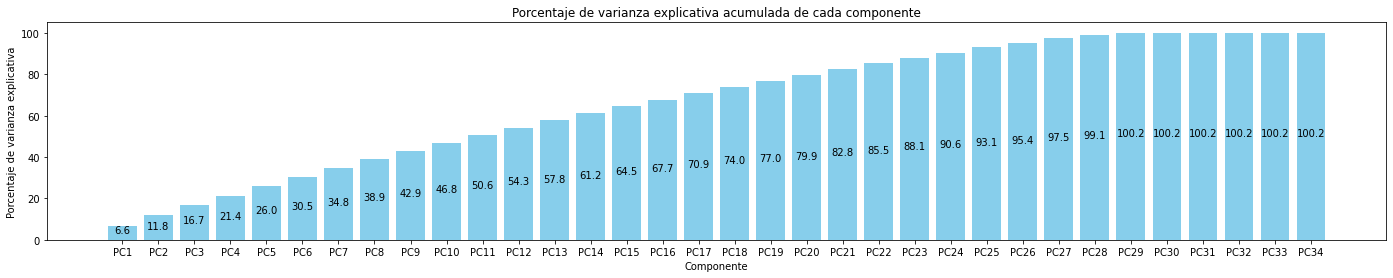

In [68]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i]//2, y[i], ha = 'center')

percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =1)

# graficar varianza por la suma acumulada de los componente
percent_variance_cum = np.cumsum(percent_variance)

datay = percent_variance_cum.tolist()

datay = np.round(datay,2)

columns = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6','PC7','PC8','PC9','PC10','PC11',
           'PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22','PC23','PC24',
           'PC25','PC26','PC27','PC28','PC29','PC30','PC31','PC32','PC33','PC34']

plt.figure(figsize=(24,4))
plt.bar(columns, height=percent_variance_cum, tick_label=columns, color='skyblue')

plt.ylabel('Porcentaje de varianza explicativa')
plt.xlabel('Componente')
plt.title('Porcentaje de varianza explicativa acumulada de cada componente')
addlabels(columns, datay)
fig.tight_layout()
plt.show()

In [69]:
transformer = make_pipeline(StandardScaler(), PCA(n_components=24))
X_apc = transformer.fit_transform(X_train)
X_testapc = transformer.fit_transform(X_test)

In [70]:
#modelo2_apc = DecisionTreeRegressor()
#modelo2_apc.fit(X_apc, y_train)
#print("Score Train: ",round(modelo2_apc.score(X_apc, y_train),3))
#print("Score Test: ",round(modelo2_apc.score(X_testapc, y_test),3))

In [71]:
#modelo3_apc = RandomForestRegressor(n_estimators=100, random_state=42)
#modelo3_apc.fit(X_apc, y_train)
#print("Score Train: ",round(modelo3_apc.score(X_apc, y_train),3))
#print("Score Test: ",round(modelo3_apc.score(X_testapc, y_test),3))

In [72]:
#transformer = make_pipeline(StandardScaler(), PCA(n_components=29))
#modelo3 = RandomForestRegressor(n_estimators=100, random_state=42)
# Create a modeling pipeline
#rf_pipe = make_pipeline(transformer, modelo3)
#rf_pipe.fit(X_train, y_train)
#print("Score Train: ",round(rf_pipe.score(X_train, y_train),3))
#print("Score Test: ",round(rf_pipe.score(X_test, y_test),3))

# Tardó 24 min en correr

In [73]:
#transformer = make_pipeline(StandardScaler(), PCA(n_components=0.95))
#modelo3 = RandomForestRegressor(n_estimators=100, random_state=42)
# Create a modeling pipeline
#rf_pipe = make_pipeline(transformer, modelo3)
#rf_pipe.fit(X_train, y_train)
#print("Score Train: ",round(rf_pipe.score(X_train, y_train),3))
#print("Score Test: ",round(rf_pipe.score(X_test, y_test),3))

# Trado 21 min en correr

## Modelo de predicción

De acuerdo a las métricas de regresión, el modelo que mejor se ajusta a los datos es el Random Forest Regressor con un R2 del 98.53%.

# Referencias

* [Datos Precio Vuelos](https://www.kaggle.com/datasets/shubhambathwal/flight-price-prediction?datasetId=1957837&sortBy=voteCount)
* [Matplotlib](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html)
* [Colors code](https://www.webucator.com/article/python-color-constants-module/)
* [Coding Dojo Plataforma](https://login.codingdojo.com/m/504/12411/100100)
* [Heat map](https://stackoverflow.com/questions/57414771/how-to-plot-only-the-lower-triangle-of-a-seaborn-heatmap)